<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/SHAPInterpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libraries
!pip install shap
!pip install catboost

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import shap

# Using catboost model
from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/carData.csv')

# Create 'age' variable
df['age'] = 2018 - df['Year'] #Using 2018 as latest year
df = df.drop(['Year'], axis = 1)
df = df[df['age'] <= 10] #Drop data more than 10 years

# Select only 'car' for model
df = df[df['vehicleType'] == 'car']
df = df.drop(['vehicleType'], axis = 1)
print(f'Total data avaliable: {df.shape[0]}')

# Create 'RV' as target
df['RV'] = df['sellingPrice'] / df['newPrice']
df = df.drop(['sellingPrice', 'newPrice'], axis = 1)

df.head(5)

Total data avaliable: 215


,carModel,carBrand,kmDriven,fuelType,sellerType,gearType,owner,age,RV
7,alto,Suzuki,2135,Petrol,Dealer,Manual,0,1,0.791667
8,alto,Suzuki,25000,Petrol,Dealer,Manual,0,2,0.721519
9,alto,Suzuki,45280,Petrol,Dealer,Manual,0,4,0.722543
10,alto,Suzuki,44542,Petrol,Dealer,Manual,0,8,0.493671
12,alto,Suzuki,10079,Petrol,Dealer,Manual,0,2,0.797872


In [ ]:
# Features and target split
X = df.drop(['RV'], axis = 1)
y = df['RV']

In [ ]:
# Model training
model = CatBoostRegressor(cat_features = ['carModel', 'carBrand', 'fuelType',
                                           'sellerType', 'gearType'],
                          verbose = 0)
model.fit(X, y)

In [ ]:
# Model accuracy
print(f'Model accuracy: {model.score(X, y):.2f}')

Model accuracy: 0.91


In [ ]:
# Prediction
pred = model.predict(X)
pred[:5]

array([0.85157497, 0.75362612, 0.65577321, 0.4488446 , 0.79822611])

In [ ]:
# SHAP Interpreter
shapExplainer = shap.TreeExplainer(model)
shapValues = shapExplainer.shap_values(X)

# Explainer details
shapExplainer.__dict__

{'data': None,
 'data_missing': None,
 'expected_value': 0.6480345135546827,
 'feature_names': None,
 'feature_perturbation': 'tree_path_dependent',
 'link': CPUDispatcher(<function identity at 0x7ff370124290>),
 'masker': None,
 'model': <shap.explainers._tree.TreeEnsemble at 0x7ff2cf5cc390>,
 'model_output': 'raw',
 'output_names': None}

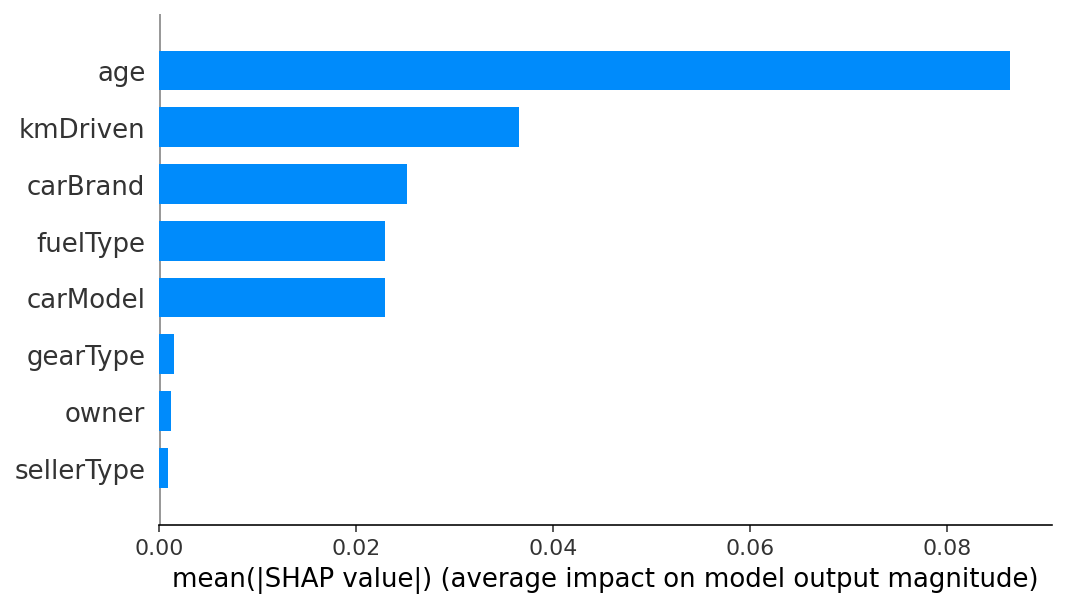

In [ ]:
# Summary features contribute in model
shap.summary_plot(shapValues, X, plot_type = 'bar')

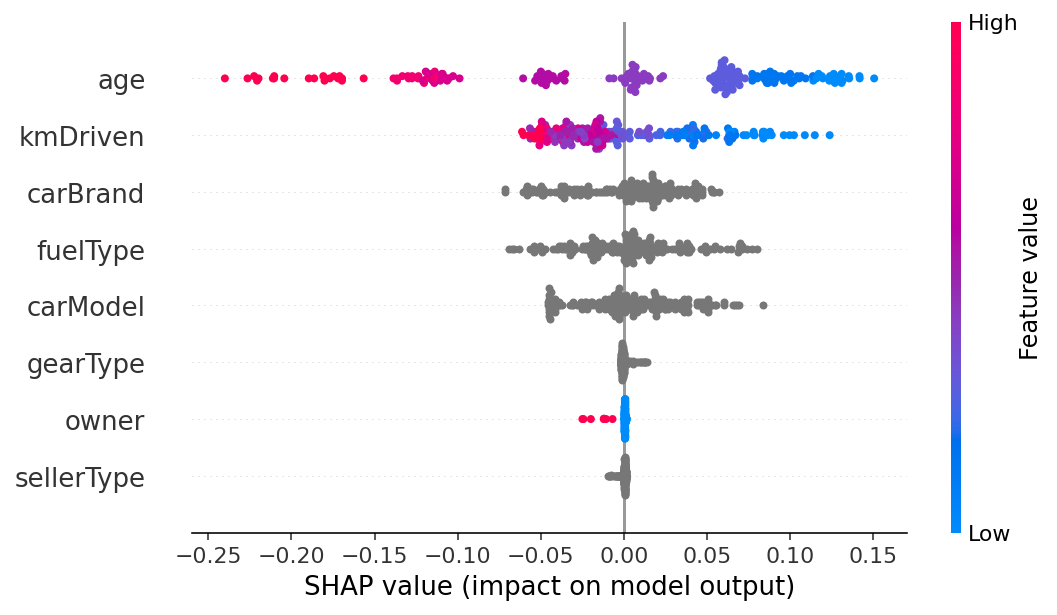

In [ ]:
# Summary features effects
shap.summary_plot(shapValues, X)

In [ ]:
# Get first row of data
X.head(1)

,carModel,carBrand,kmDriven,fuelType,sellerType,gearType,owner,age
7,alto,Suzuki,2135,Petrol,Dealer,Manual,0,1


In [ ]:
# SHAP Values
print(f'SHAP Values for features: {shapValues[0]}')
print(f'Weights of features: {np.abs(shapValues[0]) / np.sum(np.abs(shapValues[0]))}')
print(f'Number of features in model: {X.shape[1]}')

SHAP Values for features: [-0.01154624  0.01099142  0.07377095  0.0144411  -0.00014721 -0.00019238
  0.00049704  0.11572577]
Weights of features: [0.05079464 0.04835387 0.32453597 0.06352984 0.00064761 0.00084632
 0.00218658 0.50910518]
Number of features in model: 8


In [ ]:
# Calculation of prediction
shapDict = shapExplainer.__dict__ #Object to dict

predict = shapDict['expected_value'] + np.sum(shapValues[0])
print(f'Prediction from SHAP Value: {predict:.2f}')

Prediction from SHAP Value: 0.85


In [ ]:
# Features for prediction
shap.initjs() #Enable java script

# Plot
shap.force_plot(shapExplainer.expected_value,
                shap_values = shapValues[0],
                features = X.iloc[0])

In [ ]:
# Define function
def predictCase(data, num):
  explainer = shap.TreeExplainer(model)
  values = explainer.shap_values(data)
  explainerDict = explainer.__dict__

  shap.initjs() #Enable java script
  plot = shap.force_plot(shapExplainer.expected_value, shap_values = shapValues[num], features = data.iloc[num])

  # Details
  print(f'Expected value: {explainerDict["expected_value"]:.2f}')
  print(f'Effect of features: {np.sum(shapValues[num]):.2f}')
  print(f'Prediction value: {explainerDict["expected_value"] + np.sum(shapValues[num]):.2f}')
  return plot

In [ ]:
# Random from dataset
n = np.random.choice(X.shape[1], 1)
predictCase(X, n)

Expected value: 0.65
Effect of features: -0.20
Prediction value: 0.45
